# ***화승***

## ***IMPORT LIBRARY***
---

In [1]:
### Library Import 
import os
import re
import sys
import glob
import shap
import optuna
import pickle
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
from functools import partial
from pandarallel import pandarallel
from xgboost import XGBRegressor, callback as xgb_callback
from datetime import timedelta, time, datetime
from scipy.stats import truncnorm
from IPython.display import Image
from optbinning import OptimalBinning
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.patches as patches
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
warnings.filterwarnings('ignore')
plt.rc('font', family='Apple SD Gothic Neo')

# Pandas 옵션 설정 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

# Scikit-Learn 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence 

# Import fns 
from utils import * 
from hwaseung_fn import * 

## ***Load Dataset***
---

In [2]:
### Cluster Dict 
cluster_dict = {
        'cluster1': {'products': ["FFWED70284","FFWED70007","FFWED70267","FFWED70103","FFWED70199","FFSED70438","FFWED70033",
                                "FFWES60194","FFSED70498","FFSED70533","FFWED70321"],
                    'var': 'T5'},
        'cluster2': {'products': ["FFWED70019","FFWED70102","FFWED70283","FFHED70076","FFWED70338",
                                "FFHED70014","FFSED70032","FFHED70147",
                                "FFHED60009","FFHED60006"],
                    'var': 'T3'},
        'cluster3': {'products': ["HCSED50105", "HCSED60072",
                                "HCWED60031", "HCSED50391", "HCSED70092", "HCSED60024",],
                    'var': 'M/B 점도 (ML)'},
        'cluster4': {'products': ["HCSED60010", "HCSES60015", "HCWES60017",
                                "HCSED70584", "HCSED60530", "HCSED50047",
                                "HCSED40011", "HCSED20006",
                                "HCWED70019", "FCHED60002", "FCWED70009",
                                "HCSED60017", "HCSED70143"],
                    'var': 'M/B 점도 (MS)'}
        }

# Random Seed & Path 
random_seed = 22
path = '/Users/hwijongim/Library/CloudStorage/OneDrive-앰버로드/문서 - Solution/2502_화승/20.수행/22.분석과제/250408_분석_sm'

# Product 정의 
train_cluster = "cluster3"
p_codes = cluster_dict['cluster3']['products']  

# Target 
target_list = ["Ct 90"] + ["Scorch (T5)", "Scorch (T3)"] + ['Vm (T5)', "Vm (T3)", "M/B 점도 (ML)", "M/B 점도 (MS)"] + ["경도"]

# Data Import 
        # Log 
log_df = pd.read_csv(f"{path}/log_df_10s.csv")
log_df = log_df[log_df["제품코드"].isin(cluster_dict[train_cluster]["products"])] 
        # QA 
qa_df = pd.read_csv(f"{path}/qa_df.csv") 
        # Recipe
recipe_df = pd.read_csv(f"{path}/recipe_df.csv") 
        # INFO 
info = pd.read_excel(f"{path}/투입자재 CODE별 비중 정보.xlsx", header=1, index_col=0).reset_index(drop=True)
        # Weather 
weather_df = pd.read_csv(f"{path}/weather_dg.csv")
weather_df["연월일"] = weather_df["연월일"].astype(str)

# Print 
print('='*100)
print(f'Log Dataset: {log_df.shape}')
print(f'QA Dataset: {qa_df.shape}')
print(f'Recipe Dataset: {recipe_df.shape}')
print(f'INFO Dataset: {info.shape}')
print(f'Weather Dataset: {weather_df.shape}')
print('='*100)

Log Dataset: (270967, 37)
QA Dataset: (334291, 16)
Recipe Dataset: (1813072, 13)
INFO Dataset: (80, 2)
Weather Dataset: (1268, 5)


## ***Data Preprocessing***
---

In [3]:
### Log Dataset 정제 
log_df4, log_df5 = prep_log(log_df)

# Print 
print('='*100)
print(f'Log Dataset: {log_df4.shape}')
print(f'Log Train Dataset: {log_df5.shape}')
print('='*100)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Log Dataset: (251275, 39)
Log Train Dataset: (5648, 18)


In [4]:
### QA Dataset 정제 
qa_df4, qa_df5 = prep_qa(qa_df, p_codes, target_list)

# Print 
print('='*100)
print(f'Qa Dataset: {qa_df4.shape}')
print(f'Qa Train Dataset: {qa_df5.shape}')
print('='*100)

Qa Dataset: (3222, 4)
Qa Train Dataset: (3122, 11)


In [5]:
### Recipe Dataset 정제 
recipe_df = prep_recipe(recipe_df, info) 

# Print 
print('='*100)
print(f'Recipe Dataset: {recipe_df.shape}')
print('='*100)

Recipe Dataset: (123200, 2)


In [6]:
### Concat Dataset 
df1 = pd.merge(left=log_df5, right=qa_df5, on="작업지시번호-배치", how="left")
df2 = pd.merge(left=df1, right=recipe_df, on="작업지시번호-배치", how="left")
df3 = pd.merge(left=df2, right=weather_df, on="연월일", how="left").drop(["연월일"], axis=1)    

# Print 
print('='*100)
print(f'Daset Shape: {df3.shape}')
print('='*100)


Daset Shape: (5648, 32)


In [7]:
### Cluster label 생성 
clst = {1: ['FFWED70267', 'FFWED70033'],
        2: ['FFWED70007', 'FFWED70103'],
        3: ['FFSED70498', 'FFWED70321'],
        4: ['FFSED70438', 'FFSED70533'],
        5: ['FFWES60194'],
        6: ['FFWED70284', 'FFWED70199']}

# 1) 제품코드 추출
df3["제품코드_extracted"] = df3["작업지시번호-배치"].str[6:16]

# 2) 매핑 dict 생성
code_to_cluster = {c: k for k, codes in clst.items() for c in codes}

# 3) 매핑 적용 
df3["cluster"] = df3.get("cluster", pd.Series(index=df3.index))
df3["cluster"] = df3["cluster"].fillna(df3["제품코드_extracted"].map(code_to_cluster))
df3["cluster"] = df3["cluster"].astype("Int64")

df3 = df3.drop(columns=["제품코드_extracted"])
dataset = df3.drop(columns=['cluster']).reset_index(drop=True).copy()  

# Print 
print('='*100)
print(f'Train Dataset Shape: {dataset.shape}')
print('='*100)

Train Dataset Shape: (5648, 32)


In [15]:
### Target Value 확인 
# 확인할 컬럼 리스트
target_lst = [
    'cycle time',
    'Ct 90_결과',
    'M/B 점도 (ML)_결과',
    'Scorch (T5)_결과',
    'Vm (T5)_결과',
    '경도_결과'
]

dataset[target_lst].count()

cycle time        5621
Ct 90_결과            12
M/B 점도 (ML)_결과    2579
Scorch (T5)_결과       0
Vm (T5)_결과           0
경도_결과                0
dtype: int64

## ***MODELLING***
---

In [17]:
### Train Test Split 
# Targets 
targets = ['cycle time','M/B 점도 (ML)_결과']

# Cycle Time 
cycle_train_dataset, cycle_test_dataset = create_train_test_dataset(dataset, targets[0])

# M/B 점도 (ML)_결과 
ct_train_dataset, ct_test_dataset = create_train_test_dataset(dataset, targets[1])


# Print 
print('='*100)
print(f"{'cycle time':<21} | {len(cycle_train_dataset):>14,} | {len(cycle_test_dataset):>13,}")
print(f"{'M/B 점도 (ML)_결과':<19} | {len(ct_train_dataset):>14,} | {len(ct_test_dataset):>13,}")
print("="*100)

cycle time            |          4,028 |           946
M/B 점도 (ML)_결과      |          1,733 |           407


[I 2025-10-20 14:55:28,259] A new study created in memory with name: no-name-4502c005-b59b-40ac-ad0c-966369436fd2


학습할 Tree Features: 19 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 4028


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-20 14:55:33,419] Trial 0 finished with value: 3.007417032729314 and parameters: {'n_estimators': 2988, 'max_depth': 8, 'learning_rate': 0.014033864916965387, 'subsample': 0.896766910970315, 'gamma': 0.44072374828365324, 'reg_lambda': 0.003555226143693399}. Best is trial 0 with value: 3.007417032729314.
[I 2025-10-20 14:55:45,753] Trial 1 finished with value: 3.107606217001372 and parameters: {'n_estimators': 2419, 'max_depth': 10, 'learning_rate': 0.003377530294065334, 'subsample': 0.8607804510753401, 'gamma': 0.36828851225588605, 'reg_lambda': 0.003498248010579332}. Best is trial 0 with value: 3.007417032729314.
[I 2025-10-20 14:55:50,020] Trial 2 finished with value: 3.138312149315872 and parameters: {'n_estimators': 2532, 'max_depth': 9, 'learning_rate': 0.025848688735794052, 'subsample': 0.9366344539761546, 'gamma': 0.08044334580991025, 'reg_lambda': 0.06661518187546665}. Best is trial 0 with value: 3.007417032729314.
[I 2025-10-20 14:55:56,051] Trial 3 finished with val

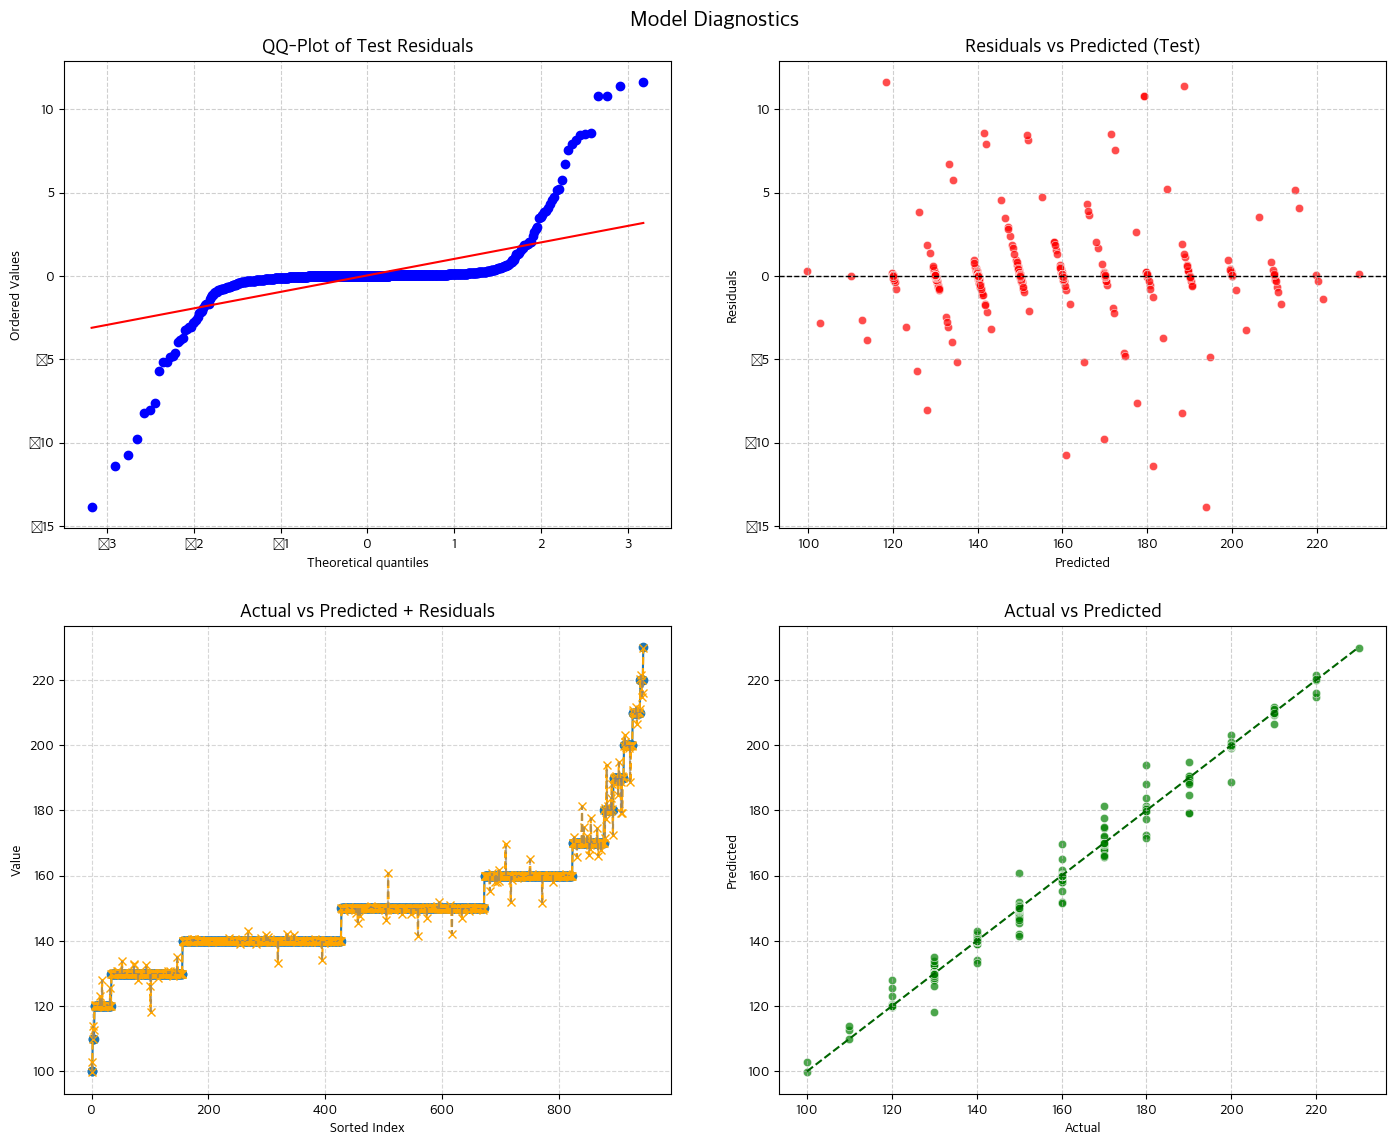

[I 2025-10-20 14:56:35,669] A new study created in memory with name: no-name-fdebcb64-4273-45c7-9213-3515832251bf


Train Accuracy
Train RMSE : 0.177
Train R2   : 1.000
Train SMAPE : 0.06
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 1.563
Test R2   : 0.992
Test SMAPE : 0.30
학습할 Tree Features: 19 | ['step1_Ram 압력', 'step2_Ram 압력', 'step3_Ram 압력', 'step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 1733


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-20 14:56:38,427] Trial 0 finished with value: 3.7558991781163384 and parameters: {'n_estimators': 442, 'max_depth': 11, 'learning_rate': 0.0026896457070386378, 'subsample': 0.7111921068922735, 'gamma': 0.08220660101417471, 'reg_lambda': 0.19449114546796195}. Best is trial 0 with value: 3.7558991781163384.
[I 2025-10-20 14:56:46,434] Trial 1 finished with value: 2.2134951299661534 and parameters: {'n_estimators': 1724, 'max_depth': 8, 'learning_rate': 0.0014409582218564273, 'subsample': 0.9817291306663066, 'gamma': 0.42857988064133556, 'reg_lambda': 0.009900592525762903}. Best is trial 1 with value: 2.2134951299661534.
[I 2025-10-20 14:56:53,060] Trial 2 finished with value: 1.9818667394564835 and parameters: {'n_estimators': 1441, 'max_depth': 11, 'learning_rate': 0.005606320840592045, 'subsample': 0.7588082748327472, 'gamma': 0.1926881819089994, 'reg_lambda': 0.07412327628061655}. Best is trial 2 with value: 1.9818667394564835.
[I 2025-10-20 14:56:56,336] Trial 3 finished w

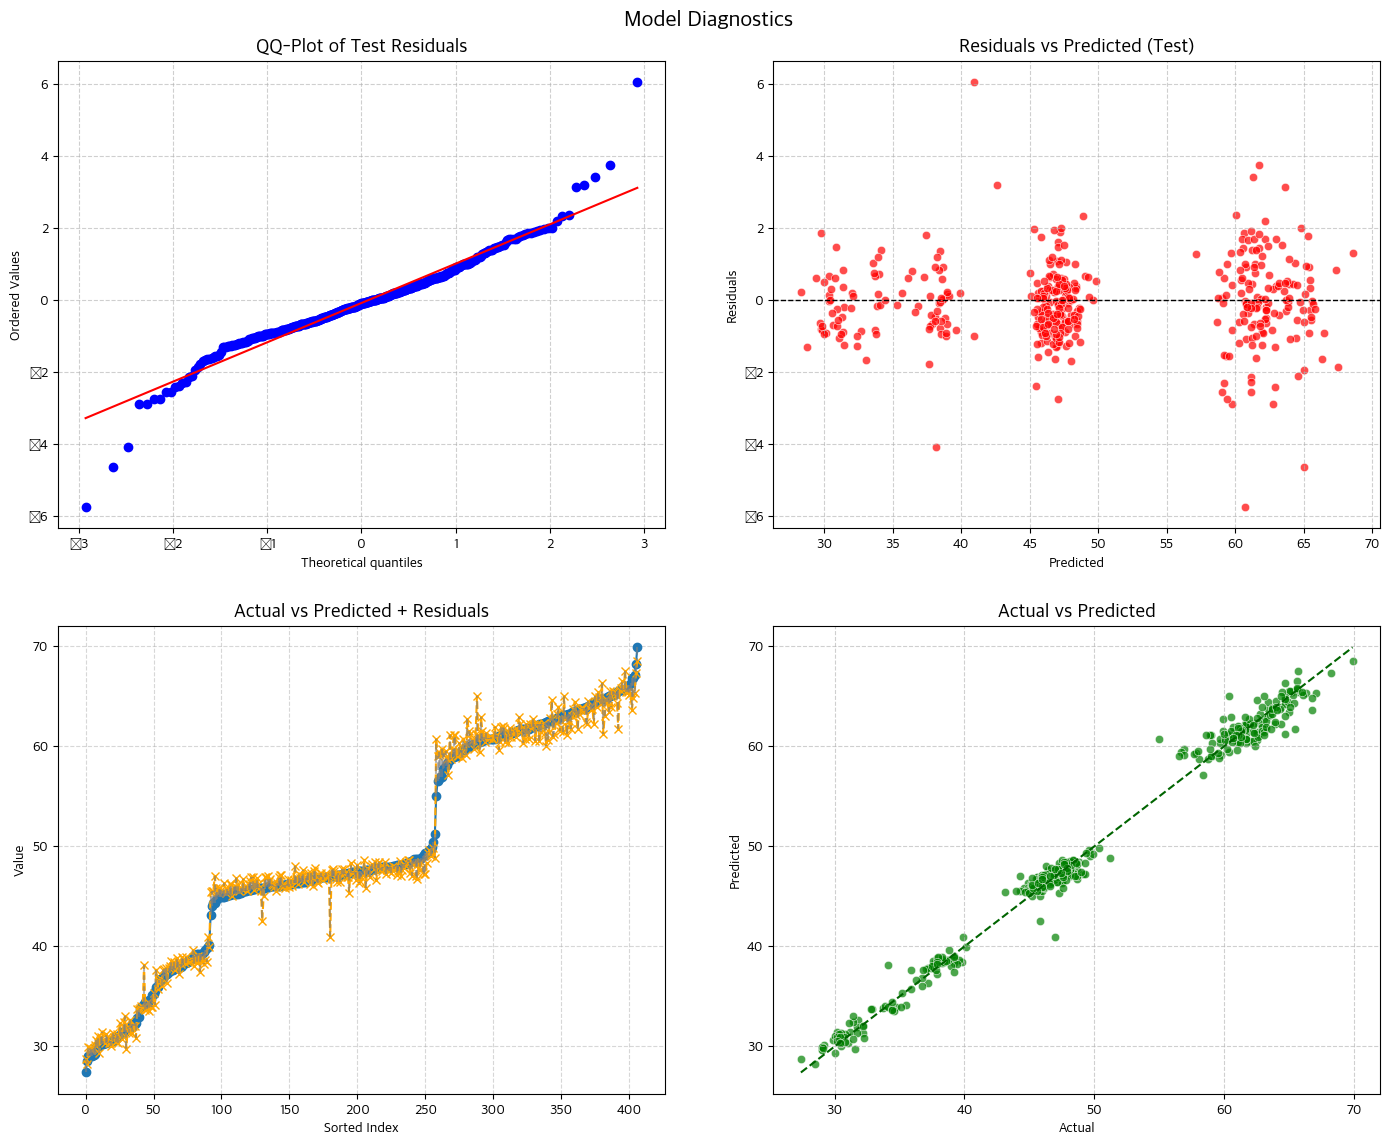

Train Accuracy
Train RMSE : 0.050
Train R2   : 1.000
Train SMAPE : 0.08
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 1.120
Test R2   : 0.990
Test SMAPE : 1.66


In [18]:
### Modelling 
# Cycle Time 
cycle_model, cycle_importance = train_tree(cycle_train_dataset, cycle_test_dataset, target_col='cycle time')

# M/B 점도 (ML)_결과 
ct_model, ct_importance = train_tree(ct_train_dataset, ct_test_dataset, target_col='M/B 점도 (ML)_결과')

In [19]:
### Feature Importance 
print('='*100)
print('Cycle Time')
print(cycle_importance)
print('-'*100)
print('M/B 점도 (ML)_결과')
print(ct_importance)
print('='*100)

Cycle Time
              Feature  Importance  rank
0           step2_전력량    0.471029     1
1         step3_mix온도    0.221020     2
2           step3_전력량    0.090717     3
3          step3_time    0.082174     4
4          step2_time    0.049705     5
5          step1_time    0.014521     6
6         step2_mix온도    0.014363     7
7         step1_mix온도    0.013632     8
8   step1_Rotor speed    0.009933     9
9   step2_Rotor speed    0.008589    10
10          step1_전력량    0.007398    11
11  step3_Rotor speed    0.004768    12
12       step2_Ram 압력    0.003392    13
13             TA_MAX    0.003010    14
14                필팩터    0.001743    15
15       step3_Ram 압력    0.001185    16
16       step1_Ram 압력    0.001093    17
17             TA_MIN    0.000932    18
18             TA_AVG    0.000795    19
----------------------------------------------------------------------------------------------------
M/B 점도 (ML)_결과
              Feature  Importance  rank
0         step2_mix온도    0.742099

[I 2025-10-20 15:00:40,704] A new study created in memory with name: no-name-20053f4f-3ea0-4477-b5b1-825444768936


학습할 Tree Features: 8 | ['step2_Ram 압력', 'step2_Rotor speed', 'step2_mix온도', 'step2_전력량', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 3893


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-20 15:00:47,932] Trial 0 finished with value: 4.084256312657234 and parameters: {'n_estimators': 2379, 'max_depth': 6, 'learning_rate': 0.022742125419945948, 'subsample': 0.7539798270881288, 'gamma': 0.038866810699550836, 'reg_lambda': 0.007220755299446802}. Best is trial 0 with value: 4.084256312657234.
[I 2025-10-20 15:00:51,008] Trial 1 finished with value: 5.293126946163792 and parameters: {'n_estimators': 1294, 'max_depth': 11, 'learning_rate': 0.022592068567093476, 'subsample': 0.9901573153758172, 'gamma': 0.42522015606681496, 'reg_lambda': 0.002647412004204837}. Best is trial 0 with value: 4.084256312657234.
[I 2025-10-20 15:00:59,685] Trial 2 finished with value: 7.433620696165826 and parameters: {'n_estimators': 1186, 'max_depth': 12, 'learning_rate': 0.0015620096627829805, 'subsample': 0.7036257903411518, 'gamma': 0.07342938721069348, 'reg_lambda': 0.014644421559038188}. Best is trial 0 with value: 4.084256312657234.
[I 2025-10-20 15:01:04,062] Trial 3 finished wit

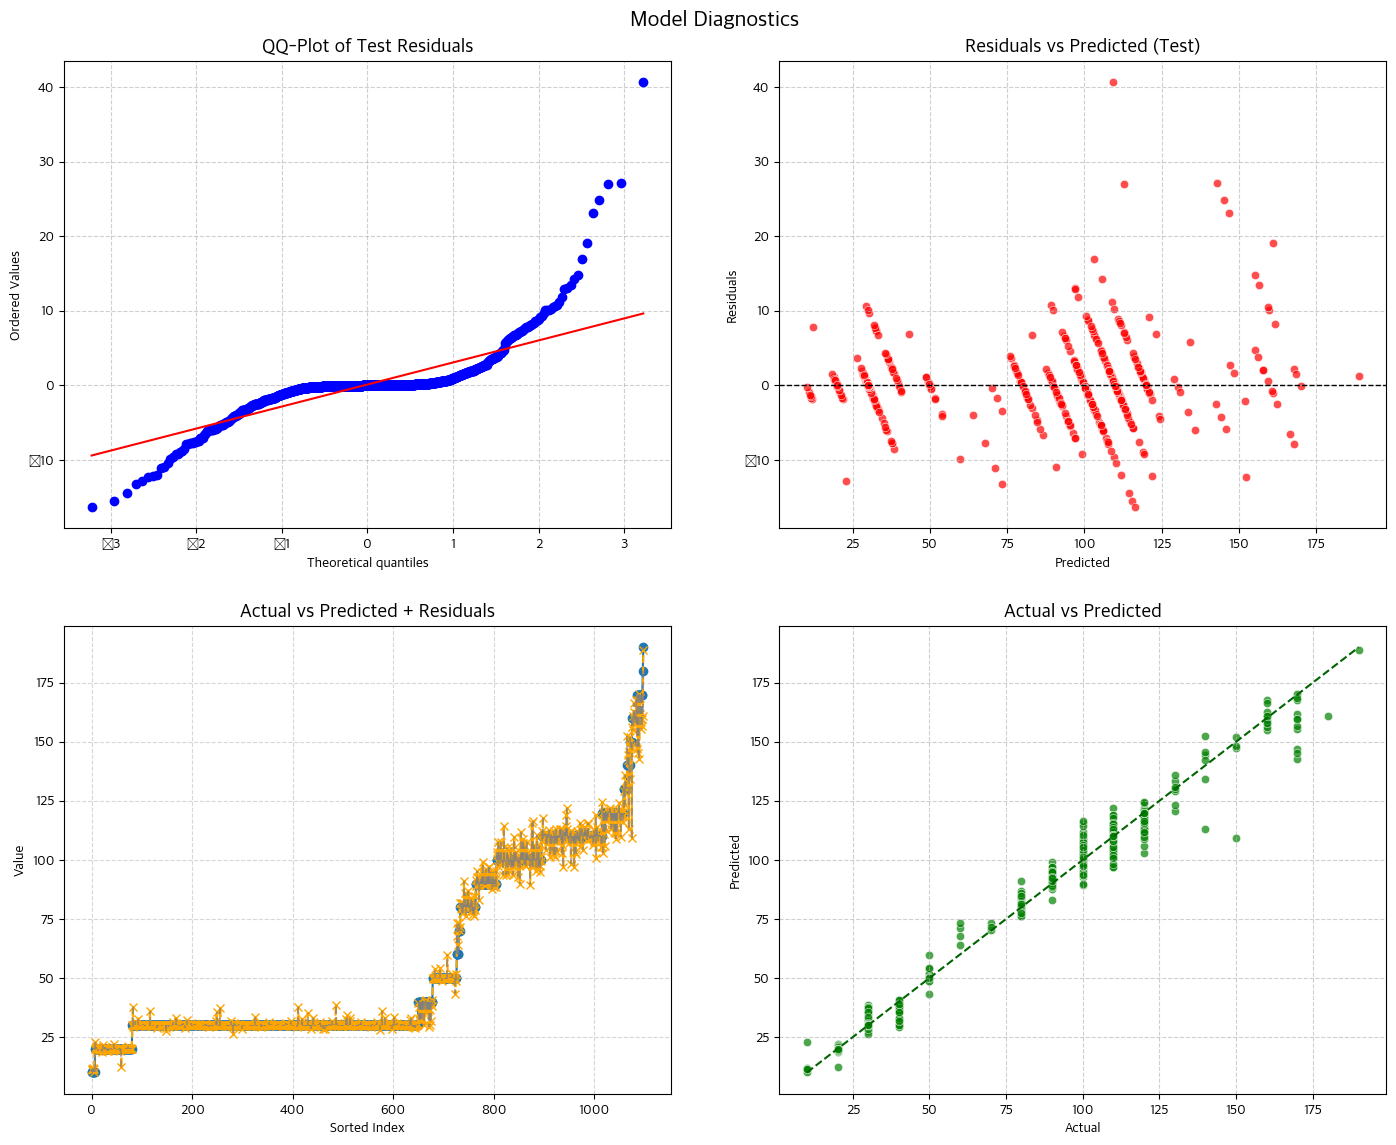

Train Accuracy
Train RMSE : 0.242
Train R2   : 1.000
Train SMAPE : 0.37
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 3.648
Test R2   : 0.991
Test SMAPE : 2.37


In [22]:
### Step Time 모델링 
# Step 2
step2_model, step2_importance = step_time_modelling(dataset, step_time='step2_time')

In [23]:
### Feature Importance 
print('='*100)
print('Step2_time')
print(step2_importance)
print('='*100)

Step2_time
             Feature  Importance  rank
0        step2_mix온도    0.773257     1
1  step2_Rotor speed    0.158227     2
2          step2_전력량    0.030370     3
3                필팩터    0.015117     4
4       step2_Ram 압력    0.008439     5
5             TA_MIN    0.005702     6
6             TA_AVG    0.005211     7
7             TA_MAX    0.003677     8
